[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Loaded Successfully! Shape: (5572, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Cleaning text (this may take a moment)...

--- Results using CountVectorizer ---

> Naive Bayes Accuracy: 0.9857
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.92      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


> Logistic Regression Accuracy: 0.9848
Top SPAM words (CountVectorizer):
['service', 'reply', 'mobile', 'new', 'stop', 'text', 'call', 'ringtone', 'claim', 't

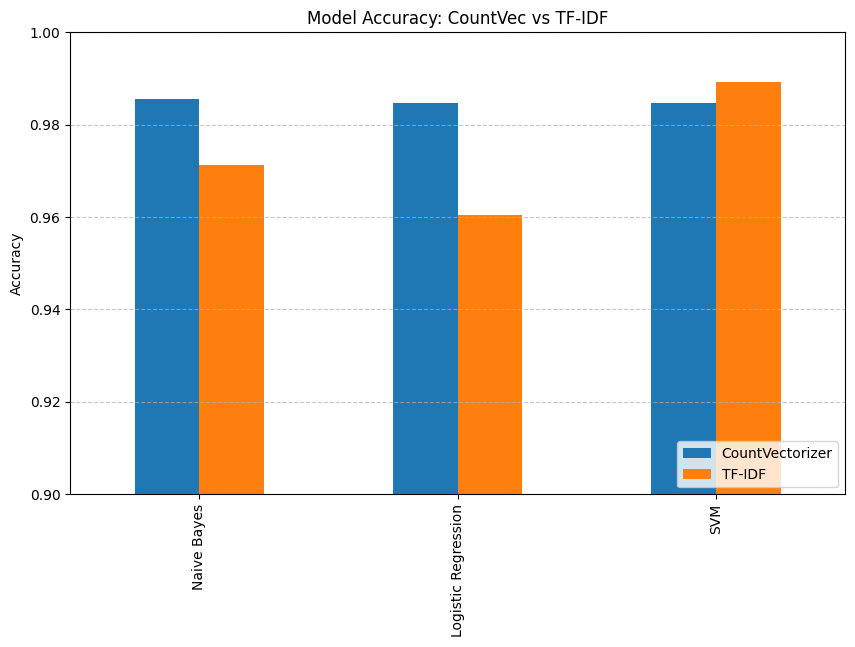


--- Live Test ---
Message: 'Congratulations! You've won a $1000 Walmart gift card. Call now to claim.'
Prediction: SPAM


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import requests
import zipfile
import io

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK stopwords (run once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ==========================================
# 1. Load Dataset (Robust Method)
# ==========================================
print("Downloading and extracting dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

# Fetch the data using requests
response = requests.get(url)

# Open the zip file in memory and read the specific file we need
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('SMSSpamCollection') as f:
        df = pd.read_csv(f, sep='\t', names=['label', 'message'], header=None)

print(f"Dataset Loaded Successfully! Shape: {df.shape}")
print(df.head())

# ==========================================
# 2. Text Cleaning & Preprocessing
# ==========================================
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove Punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # 3. Remove Stopwords
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

print("\nCleaning text (this may take a moment)...")
df['clean_message'] = df['message'].apply(clean_text)

# Map labels to numbers: ham=0, spam=1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Split Data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_message'], df['label_num'], test_size=0.2, random_state=42
)

# ==========================================
# 3. Vectorization & Model Comparison Logic
# ==========================================
def evaluate_models(vectorizer, name):
    print(f"\n--- Results using {name} ---")
    
    # Transform text
    X_train = vectorizer.fit_transform(X_train_raw)
    X_test = vectorizer.transform(X_test_raw)
    
    models = {
        "Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM": SVC(kernel='linear')
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        results[model_name] = acc
        
        print(f"\n> {model_name} Accuracy: {acc:.4f}")
        # Only print full report for the best model to save space
        if model_name == "Naive Bayes": 
            print(classification_report(y_test, y_pred))
        
        # Bonus: Feature Importance (for Logistic Regression)
        if model_name == "Logistic Regression":
            feature_names = vectorizer.get_feature_names_out()
            coefs = model.coef_[0]
            top_positive = np.argsort(coefs)[-10:] # Most Spam
            print(f"Top SPAM words ({name}):")
            print([feature_names[i] for i in top_positive])
            
    return results

# ==========================================
# 4. Execution: CountVectorizer vs TF-IDF
# ==========================================

# A. CountVectorizer
cv = CountVectorizer()
cv_results = evaluate_models(cv, "CountVectorizer")

# B. TF-IDF
tfidf = TfidfVectorizer()
tfidf_results = evaluate_models(tfidf, "TF-IDF")

# ==========================================
# 5. Final Comparison & Visualization
# ==========================================
print("\n--- Final Accuracy Comparison ---")
comparison_df = pd.DataFrame({
    "CountVectorizer": cv_results,
    "TF-IDF": tfidf_results
})
print(comparison_df)

# Plotting
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Accuracy: CountVec vs TF-IDF")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==========================================
# 6. Test Your Own Message (Bonus)
# ==========================================
def predict_message(message):
    clean = clean_text(message)
    vec = cv.transform([clean]) # Using CountVectorizer for this example
    model = MultinomialNB()
    model.fit(cv.transform(X_train_raw), y_train) # Quick retrain for demo
    prediction = model.predict(vec)
    return "SPAM" if prediction[0] == 1 else "HAM"

print("\n--- Live Test ---")
test_msg = "Congratulations! You've won a $1000 Walmart gift card. Call now to claim."
print(f"Message: '{test_msg}'\nPrediction: {predict_message(test_msg)}")